In [1]:
using Distributions
using Plots
using StatsFuns: logit, logistic
using Roots
using StatsBase: ecdf

In [2]:
"""
事前分布 Beta(a, b) のもとでn回中ｋ回成功の場合の事後分布は Beta(k+a, n-k+b) になる。
デフォルトでは a = b = 1 の一様事前分布を採用することにする。
"""
posterior_dist(n, k; a=1, b=a) = Beta(k + a, n - k + b)

"""
pvalue_bayes(n, p, k; a, b) < α ⇔ p ∉ (ベイズ版100(1-α)%信用区間)
"""
function pvalue_bayes(n, p, k; a = 1, b = a)
    posterior = posterior_dist(n, k; a, b)
    v0 = logpdf(posterior, p)
    f(t) = logpdf(posterior, logistic(t)) - v0
    m = params(posterior) |> ((α, β),) -> (α - 1)/(α + β - 2)
    if m ≤ 0
        s = ccdf(posterior, p)
    elseif m ≥ 1
        s = cdf(posterior, p)
    elseif p ≤ m
        q = logistic(find_zero(f, min(50, logit(m) + 1)))
        s = cdf(posterior, p) + ccdf(posterior, q)
    else
        q = logistic(find_zero(f, max(-50, logit(m) - 1)))
        s = cdf(posterior, q) + ccdf(posterior, p)
    end
    min(1, s)
end

"""
Bernoulli(p)分布の独立試行をNまで行うとき、
pがベイズ版信用区間から外れるまでの試行回数をL個計算
"""
function bayeshacking(N, p; α = 0.05, L = 10^4, a = 1, b = a)
    numtrials = fill(N + 1, L)
    for i in 1:L
        k = 0
        for n in 1:N
            k += rand(Bernoulli(p))
            if pvalue_bayes(n, p, k; a, b) < α
                numtrials[i] = n
                break
            end
        end
    end
    numtrials
end

bayeshacking

In [3]:
numtrials = bayeshacking(10^3, 0.5)
[(n, ecdf(numtrials)(n)) for n in (10, 100, 1000)]

3-element Vector{Tuple{Int64, Float64}}:
 (10, 0.2231)
 (100, 0.4108)
 (1000, 0.559)

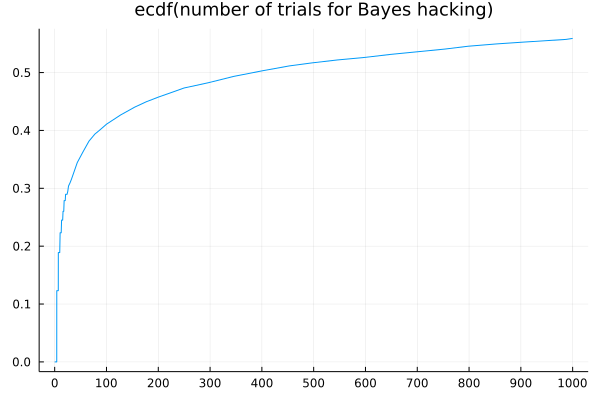

In [4]:
plot(n -> ecdf(numtrials)(n), 0, 10^3; label="", xtick=0:100:1000)
title!("ecdf(number of trials for Bayes hacking)"; titlefontsize=12)